# Simple Feature Extraction

In [1]:
import os
import sys
import json
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, Any
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import Config
from prompts import PromptManager
from services import OpenAIService
from feature_extraction import SimpleFeatureExtractor

# Load configuration
config = Config()

openai_service = OpenAIService(config.OPENAI_API_KEY, config)
prompt_manager = PromptManager()
feature_extraction = SimpleFeatureExtractor(openai_service, prompt_manager)

In [2]:
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'
logging.basicConfig(level=logging.INFO)

In [3]:
old_products = pd.read_csv("./data/filtered_products.csv")
raw_data = old_products[["id", "raw_data"]].sample(n=10).copy()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 771 to 489
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10 non-null     object
 1   raw_data  10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [4]:
raw_data.head()

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Feature Extractions

In this section, we'll compare the feature extraction performance of four different models: gpt-4o, gpt-4o-mini, o1-preview, and o1-mini. We'll evaluate them based on token usage, cost, execution time, the number of "Not Available" features, and the quality of extracted features.

### Helper Functions

First, let's define some helper functions to assist with our analysis:


In [5]:
def count_none_values(data: Dict[str, Any]) -> int:
    """Recursively count None values in a nested dictionary."""
    count = 0
    for value in data.values():
        if isinstance(value, dict):
            count += count_none_values(value)
        elif isinstance(value, list):
            count += sum(1 for item in value if item is None)
        elif value is None:
            count += 1
    return count


def calculate_cost(input_tokens: int, output_tokens: int, model: str) -> float:
    """Calculate the cost based on input and output tokens for a given model."""
    costs = {
        "gpt-4o": (0.01 / 1000, 0.015 / 1000),  # $10 per 1M input, $15 per 1M output
        "gpt-4o-mini": (0.00015 / 1000, 0.0006 / 1000),  # $0.15 per 1M input, $0.60 per 1M output
        "o1-preview": (0.015 / 1000, 0.06 / 1000),  # $15 per 1M input, $60 per 1M output
        "o1-mini": (0.003 / 1000, 0.012 / 1000),  # $3 per 1M input, $12 per 1M output
    }
    input_cost, output_cost = costs[model]
    return (input_tokens * input_cost) + (output_tokens * output_cost)


async def extract_features(extractor, raw_data: str, model: str) -> Dict[str, Any]:
    """Extract features using the specified model and return results with metadata."""
    start_time = time.time()
    try:
        extracted_features, input_tokens, output_tokens = await extractor.extract_data(raw_data, model=model)
        end_time = time.time()

        return {
            "features": extracted_features,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "time_taken": end_time - start_time,
            "none_value_count": count_none_values(extracted_features),
            "cost": calculate_cost(input_tokens, output_tokens, model),
            "error": None,
        }
    except Exception as e:
        end_time = time.time()
        logging.error(f"Error extracting features with model {model}: {str(e)}")
        return {
            "features": None,
            "input_tokens": 0,
            "output_tokens": 0,
            "time_taken": end_time - start_time,
            "none_value_count": 0,
            "cost": 0,
            "error": str(e),
        }

In [15]:
test_data = raw_data["raw_data"].iloc[0]
print(f"test_data: {test_data}")
await extract_features(feature_extraction, test_data, "o1-preview")

2024-09-19 22:41:35,772 - INFO - Generating prompt for simple_data_extraction with kwargs: {'raw_data': 'Industrial Motherboards Systems Features EPCT Series System Thin barebone system desktop low profile MiniITX motherboard Thin design mm height Thin barebone multiIO ports suitable variety application environments DCin design Easy quick installation additional peripherals One shockresistant drive bay Support WallVESADin RailRack mounting Kit Lock type DC power jack RoHS COMPLIANT EC NEW Specifications Model Name EPCTCAYE EPCTAYE Barebone system Description Fanbase barebone w CPU wo HDD SSD Memory Adapter Processor System Compatible Motherboard AIMBGAE Thermal solution x chassis fan cmCFM CPU Intel Celeron G Processor C GT M GHz W Intel Core iTE Processor C GT M GHz W BIOS AMI EFI Mbit SPI Memory Socket x PIN DDR SODIMM NonECC Technology Dual Channel DDR MHz SDRAM Max Capacity GB GB per SODIMM Graphics Chipset integrated Intel HD Graphics Supports OpenGL x DirectX OpenCL X Storage HDD

test_data: Industrial Motherboards Systems Features EPCT Series System Thin barebone system desktop low profile MiniITX motherboard Thin design mm height Thin barebone multiIO ports suitable variety application environments DCin design Easy quick installation additional peripherals One shockresistant drive bay Support WallVESADin RailRack mounting Kit Lock type DC power jack RoHS COMPLIANT EC NEW Specifications Model Name EPCTCAYE EPCTAYE Barebone system Description Fanbase barebone w CPU wo HDD SSD Memory Adapter Processor System Compatible Motherboard AIMBGAE Thermal solution x chassis fan cmCFM CPU Intel Celeron G Processor C GT M GHz W Intel Core iTE Processor C GT M GHz W BIOS AMI EFI Mbit SPI Memory Socket x PIN DDR SODIMM NonECC Technology Dual Channel DDR MHz SDRAM Max Capacity GB GB per SODIMM Graphics Chipset integrated Intel HD Graphics Supports OpenGL x DirectX OpenCL X Storage HDD bay support HDDSSD max mm height mSATA Slot Fullsize Ethernet Interface Mbps Controller LAN R

{'features': None,
 'input_tokens': 0,
 'output_tokens': 0,
 'time_taken': 0.003271818161010742,
 'none_value_count': 0,
 'cost': 0,
 'error': "'Could not automatically map o1-preview to a tokeniser. Please use `tiktoken.get_encoding` to explicitly get the tokeniser you expect.'"}

In [7]:
import asyncio

models = ["gpt-4o", "gpt-4o-mini", "o1-preview", "o1-mini"]
results = {model: [] for model in models}


async def process_all_data():
    for index, row in raw_data[:2].iterrows():
        for model in models:
            result = await extract_features(feature_extraction, row["raw_data"], model)
            result["id"] = row["id"]
            results[model].append(result)


await process_all_data()

2024-09-19 16:35:39,972 - INFO - Generating prompt for simple_data_extraction with kwargs: {'raw_data': 'Industrial Motherboards Systems Features EPCT Series System Thin barebone system desktop low profile MiniITX motherboard Thin design mm height Thin barebone multiIO ports suitable variety application environments DCin design Easy quick installation additional peripherals One shockresistant drive bay Support WallVESADin RailRack mounting Kit Lock type DC power jack RoHS COMPLIANT EC NEW Specifications Model Name EPCTCAYE EPCTAYE Barebone system Description Fanbase barebone w CPU wo HDD SSD Memory Adapter Processor System Compatible Motherboard AIMBGAE Thermal solution x chassis fan cmCFM CPU Intel Celeron G Processor C GT M GHz W Intel Core iTE Processor C GT M GHz W BIOS AMI EFI Mbit SPI Memory Socket x PIN DDR SODIMM NonECC Technology Dual Channel DDR MHz SDRAM Max Capacity GB GB per SODIMM Graphics Chipset integrated Intel HD Graphics Supports OpenGL x DirectX OpenCL X Storage HDD

In [10]:
def analyze_model_results(model_results):
    df = pd.DataFrame(model_results)
    return {
        "avg_input_tokens": df["input_tokens"].mean(),
        "avg_output_tokens": df["output_tokens"].mean(),
        "avg_time_taken": df["time_taken"].mean(),
        "avg_none_value_count": df["none_value_count"].mean(),
        "total_cost": df["cost"].sum(),
        "error_count": df["error"].notnull().sum(),
    }


analysis_results = {model: analyze_model_results(results[model]) for model in models}
analysis_df = pd.DataFrame(analysis_results).T
analysis_df.index.name = "Model"
analysis_df

,avg_input_tokens,avg_output_tokens,avg_time_taken,avg_none_value_count,total_cost,error_count
Model,,,,,,
gpt-4o,1682.00,902.50,25.91,1.50,0.09,0.00
gpt-4o-mini,1682.00,697.50,10.31,0.00,0.00,0.00
o1-preview,0.00,0.00,0.00,0.00,0.00,2.00
o1-mini,0.00,0.00,0.00,0.00,0.00,2.00


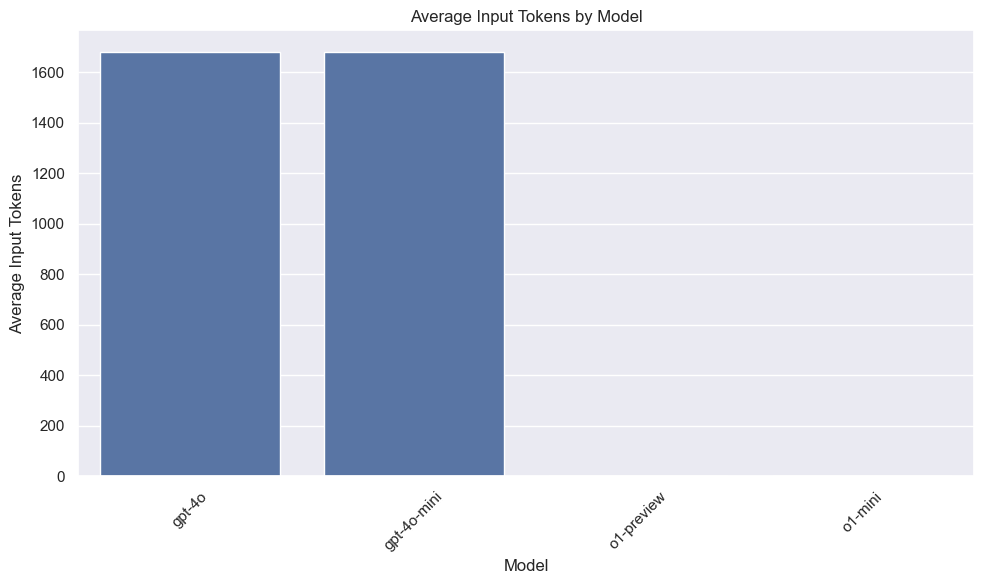

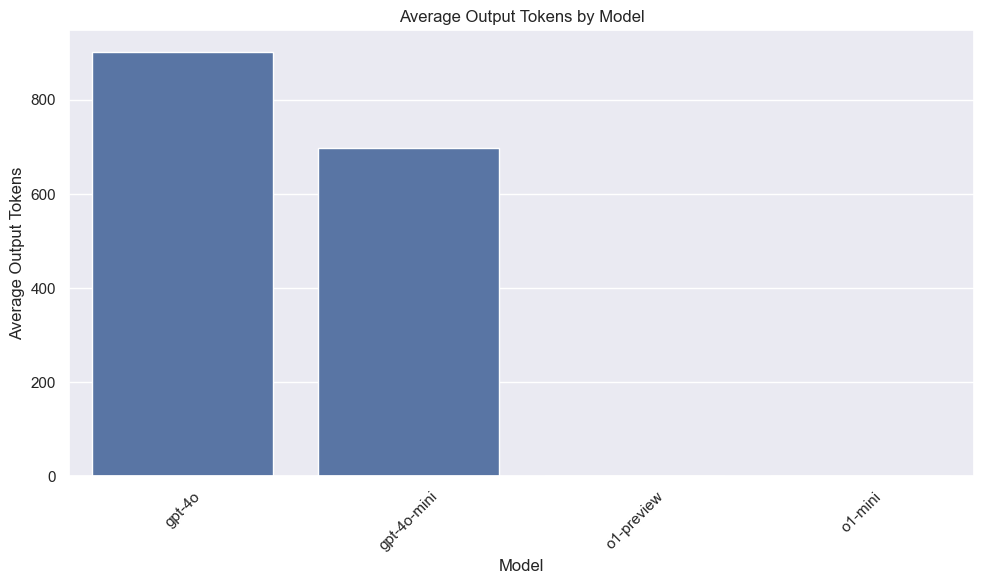

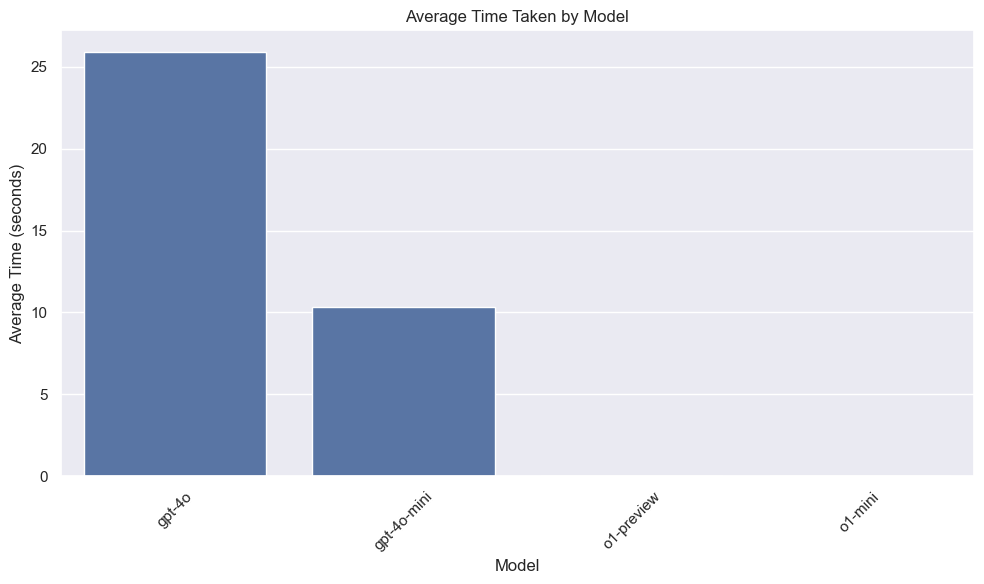

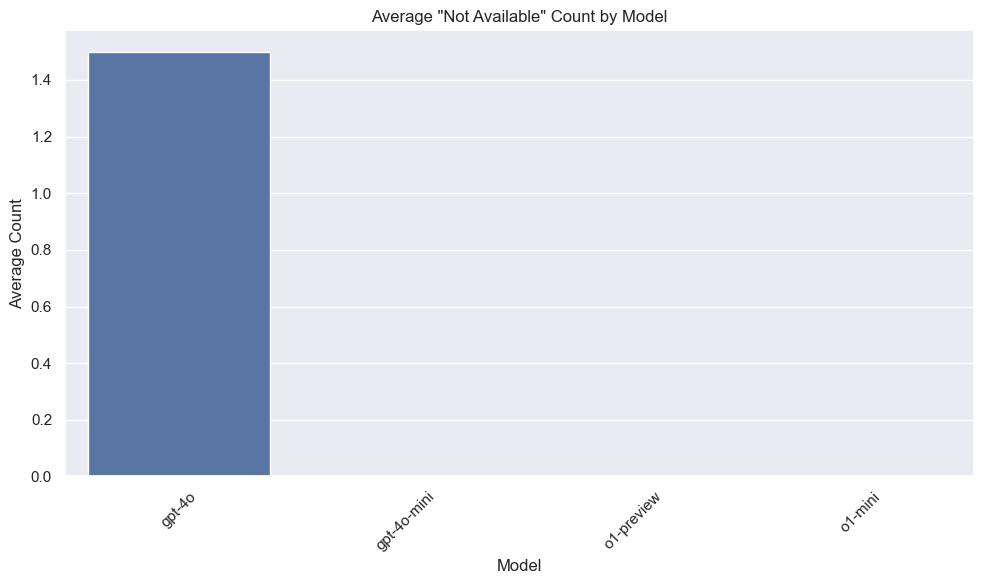

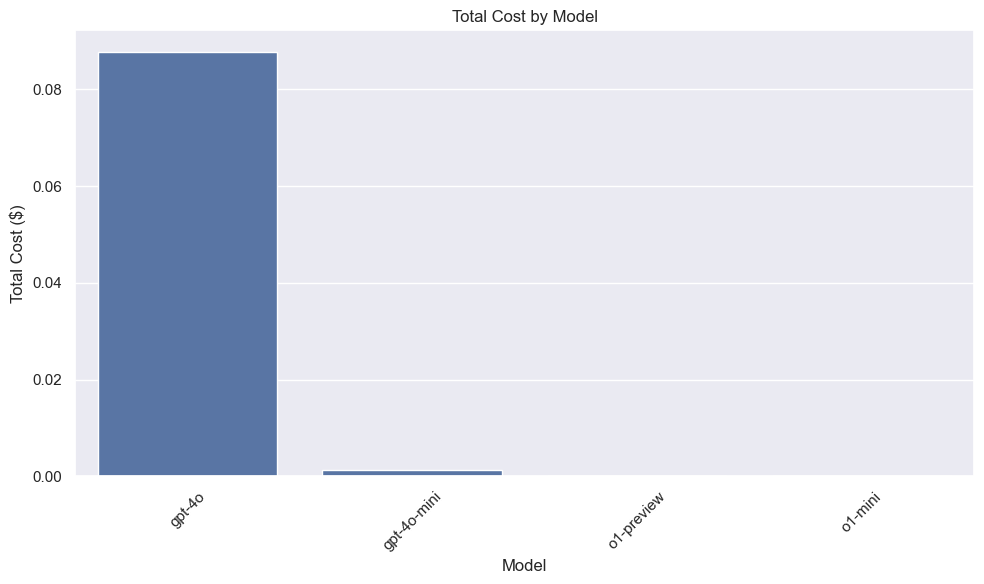

In [13]:
def plot_comparison(data, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data.index, y=metric, data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_comparison(analysis_df, 'avg_input_tokens', 'Average Input Tokens by Model', 'Average Input Tokens')
plot_comparison(analysis_df, 'avg_output_tokens', 'Average Output Tokens by Model', 'Average Output Tokens')
plot_comparison(analysis_df, 'avg_time_taken', 'Average Time Taken by Model', 'Average Time (seconds)')
plot_comparison(analysis_df, "avg_none_value_count", 'Average "Not Available" Count by Model', "Average Count")
plot_comparison(analysis_df, "total_cost", "Total Cost by Model", "Total Cost ($)")

### Quality Assessment

To assess the quality of extracted features, we'll manually review a sample of the results:


In [11]:
def display_sample_results(model, num_samples=2):
    print(f"Sample results for {model}:")
    for sample in results[model][:num_samples]:
        print(f"ID: {sample['id']}")
        if sample["error"]:
            print(f"Error: {sample['error']}")
        else:
            print(json.dumps(sample["features"], indent=2))
            print(f"None Value Count: {sample['none_value_count']}")
        print(f"Time Taken: {sample['time_taken']:.2f} seconds")
        print(f"Cost: ${sample['cost']:.4f}")
        print("\n" + "=" * 50 + "\n")

In [14]:
for model in models:
    display_sample_results(model)

Sample results for gpt-4o:
ID: EPC-T22857A-00Y1E
{
  "name": "EPCT Series System",
  "manufacturer": "Advantech",
  "is_prototype": false,
  "form_factor": "Thin barebone system, low profile, Mini-ITX motherboard, 44 mm height",
  "processor": {
    "manufacturer": "Intel",
    "series": null,
    "model": "Celeron G3900TE / Core i3-6100TE / Core i5-6500TE",
    "speed": "2.3 GHz / 2.7 GHz / 2.3 GHz",
    "max_speed": null,
    "core_count": 2,
    "thread_count": 4,
    "architecture": "x86-64",
    "features": [
      "Intel HD Graphics",
      "Supports OpenGL 4.4",
      "DirectX 12",
      "OpenCL 2.0"
    ],
    "tdp": "35 W"
  },
  "memory": {
    "ram_type": "DDR4",
    "ram_speed": "2133 MHz",
    "ram_capacity": "32 GB",
    "ram_configuration": "2 x 260-pin DDR4 SODIMM, Non-ECC, Dual Channel"
  },
  "storage": {
    "storage_type": "HDD/SSD, mSATA",
    "storage_capacity": null
  },
  "gpu_model": "Integrated Intel HD Graphics",
  "interfaces": {
    "display_outputs": [
   